<H1>Sentiment Analysis: Amazon Reviews</H1>
<H3>By Michael Klear</H3><br>
This sentiment analysis project uses <a href='http://jmcauley.ucsd.edu/data/amazon/'>this dataset</a> of Amazon product reviews. I try to make predictions of star ratings based on content of review.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from scipy.sparse import coo_matrix
import xgboost as xgb
from sklearn.model_selection import cross_val_score

/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_json('./rVG5.json', lines=True)
df = df.sample(frac=1, random_state=111)

This is a simple dataset, with just a handful of important columns:

In [3]:
df.head(2)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
133556,B002FQM5OG,"[0, 0]",2,"Even though I've had this kit for awhile, it d...","03 28, 2010",AKCZIJ6ZHE41D,"Jarucia Jaycox ""~A Pink American""",Not so Good Drum Kit,1269734400
211868,B009CCTSIM,"[1, 1]",5,This thing is long enough to comfortably play ...,"01 24, 2013",A1OXMAQIY6JUI9,J. Thompson,It's a piece of stretched copper... IT WORKS,1358985600


<H2>Outcome Variable:</H2>
The goal is to classify "positive" and "negative" reviews based on the content of the review text. Since there are five ratings, I need to decide what star rating to count as positive and what star ratings to count as negative. Here's the ratings distribution:

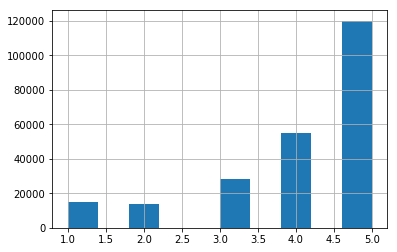

In [4]:
df.overall.hist();
plt.show();

In [5]:
#A peek at a four star rating: clearly positive
df[df.overall==4].iloc[7].reviewText

"I'm not sure which one I like more, this game or Yoshi's Cookie. Both have different rules of gameplay, but both are also challenging. I've always been a sucker for Tetris-style games (pieces fall down, you try to get rid of them) For a NES game, the controls and graphics were smooth. There's not much I can say that other reviewers haven't already said. If you like puzzle games, you should enjoy this."

Four and five star ratings are clearly positive, while three is unclear and often neutral. Based on the idea that 3 ratings don't usually encourage readers to purchase the product, I'll call all four and five star reviews "positive," (1) and group all others as "negative" (or zero).

In [6]:
df['pos'] = np.where(df.overall > 2, 1, 0)
class_imb = 1-(df.pos.sum()/len(df))
print('proportion of negative ratings: ', class_imb)

proportion of negative ratings:  0.123030459919


We see that most ratings, about 88%, are positive. This gives us a slight class imbalance that could tip our model in favor of positive ratings.<br>
<h2>Features</h2><br>
I build a few features.

The tfidf vectorizer helps us impliment a "bag of words" model of the text in reviews:

In [7]:
#Initialize and train vectorizer on corpus
#Parameters chosen after some tinkering. More tinkering can probably improve model performance.
tv = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', min_df=.00001, max_df=.9)
tv.fit(df.reviewText)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=1e-05,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

I'll also hand build some features:

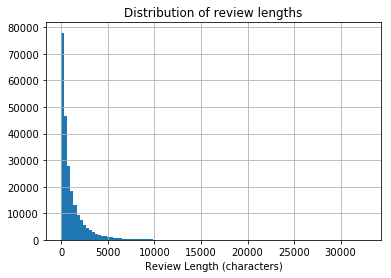

In [8]:
#Convert text to lower case characters
df['reviewText'] = df.reviewText.str.lower()

#Measure the length of review text in number of characters
df['review_length'] = df.reviewText.apply(len)

#Record the number of people who found review helpful
df['helpful_clicks'] = df.helpful.apply(lambda x: x[1])

def get_help_rating(helpful):
    """Rates helpfulness based on overall number of clicks. Returns zero if zero
    total clicks. If every click found unhelpful, returns negative value (number of unhelpful
    clicks)
    """
    if helpful[1] == 0:
        return 0
    elif helpful[1] > 0:
        if helpful[0] == 0:
            return -helpful[1]
        else:
            return helpful[0]/helpful[1]
    
#Get helpful rating
df['helpful_rating'] = df.helpful.apply(get_help_rating)
#Get length of summary
df['summary_length'] = df.summary.apply(len)

df.review_length.hist(bins=100);
plt.title('Distribution of review lengths');
plt.xlabel('Review Length (characters)');
plt.show(); #See the distribution of review lengths

In [9]:
features = tv.transform(df.reviewText)
features #See how many features we've got... Over one million!!

<231780x1192329 sparse matrix of type '<class 'numpy.float64'>'
	with 30091877 stored elements in Compressed Sparse Row format>

<H2>Holdout Group</H2><br>
To evaluate our model, we'll reserve 20% of our samples in a holdout group.

In [10]:
cutoff = int(.8 * len(df))

ft = [                #Pick hand-built features
    'review_length',
    'helpful_clicks',
    'helpful_rating',
    'summary_length'
]


train = df[:cutoff]
ft_train = scipy.sparse.hstack((features[:cutoff], np.array(df[ft][:cutoff]))) #Add my features to sparse matrix

test = df[cutoff:]
ft_test = scipy.sparse.hstack((features[cutoff:], np.array(df[ft][cutoff:]))) #Repeat for training set

#Define outcome variable
Y_train = train.pos
Y_test = test.pos

In [11]:
#Take a look at imbalance of test set for evaluation comparison
print('test set imbalance: ', Y_test.sum()/len(Y_test))

test set imbalance:  0.876779704893


<H2>Model: XGBoost</H2><br>
XGBoost is a great algorithm for this problem. It can efficiently work with the sparse features and pick up on subtle interactions between features.

In [14]:
#Convert data to xgb datamatrices
dtrain = xgb.DMatrix(ft_train, label=Y_train)
dtest = xgb.DMatrix(ft_test, label=Y_test)

In [15]:
#Set up our model for training. Parameters chosen after much tinkering.
param = {
    'max_depth': 7, 
    'eta': 1,  #Notice high eta and max depth. Helps work with vast number of features
    'silent': 0, 
    'objective': 
    'binary:logistic', 
    'scale_pos_weight': (class_imb),  #Tell model about class imbalance
    'nthread':4,
    'eval_metric':'error'
}

plst = param.items()
num_round = 500
evallist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(plst, dtrain, num_round, evallist, verbose_eval=False) #We can watch outputs to see model slowly optimize.
#Breaks 90% accuracy at around 410 iterations, with vanishing returns around 500.

Y_ = np.where(bst.predict(dtrain)>.5, 1, 0)
tb = pd.crosstab(Y_, Y_train)
print(tb)
print((tb.iloc[0, 0]+tb.iloc[1, 1])/tb.sum().sum())

Y_ = np.where(bst.predict(dtest)>.5, 1, 0)
tb = pd.crosstab(Y_, Y_test)
print(tb)
print((tb.iloc[0, 0]+tb.iloc[1, 1])/tb.sum().sum())

pos        0       1
row_0               
0      22768    4466
1         36  158154
0.975720510829
pos       0      1
row_0             
0      3933   2679
1      1779  37965
0.90383121926


In [16]:
Y_ = np.where(bst.predict(dtrain)>.5, 1, 0)
tb = pd.crosstab(Y_, Y_train)
print('Training Set Performance: \n')
print(tb)
print('accuracy: ', (tb.iloc[0, 0]+tb.iloc[1, 1])/tb.sum().sum())

Y_ = np.where(bst.predict(dtest)>.5, 1, 0)
tb = pd.crosstab(Y_, Y_test)
print('Test Set Performance: \n')
print(tb)
print('accuracy: ', (tb.iloc[0, 0]+tb.iloc[1, 1])/tb.sum().sum())

Training Set Performance: 

pos        0       1
row_0               
0      22768    4466
1         36  158154
accuracy:  0.975720510829
Test Set Performance: 

pos       0      1
row_0             
0      3933   2679
1      1779  37965
accuracy:  0.90383121926


<H2>Results Interpretation</H2><br>
The model does a decent job predicting sentiment; at least it improves over random guessing. There's a mix of type I and type II errors, and we coul work to reduce either type of error based on our priorities as a business (for example, Amazon) to achieve a certain outcome.

A quick look at feature importance:

In [32]:
#Grab top 1000 most important features
ft_imp = bst.get_fscore()
ft_imps = pd.DataFrame(columns=['feature', 'importance'], index=range(0, len(ft_imp)))
ft_imps['feature'] = ft_imp.keys()
ft_imps['importance'] = ft_imp.values()
top_1000 = ft_imps.iloc[:1000]

In [44]:
#Look up feature names
names = tv.get_feature_names()
names += ft
def get_feature_name(feature_, names=names):
    """Takes a feature from xgboost feature importance output
    (format f####### where ####### is feature number) and
    finds it.
    """
    num = int(feature_[1:])a
    return names[num]

top_1000['name'] = top_1000.feature.apply(get_feature_name)

/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [48]:
#Take a look
top_1000.sort_values('importance', ascending=False).head(50)

,feature,importance,name
9,f416639,546,game
0,f1192331,495,helpful_rating
78,f1192332,412,summary_length
1,f1192330,368,helpful_clicks
50,f1192329,365,review_length
45,f604883,306,like
49,f562874,261,just
12,f432218,209,games
76,f784132,192,play
31,f457319,174,good


Four of the top five most important features are my very own, hand-built ones! That's great to see. Surprisingly, the word "game" makes the most important feature. It's kind of strange because it's a word I'd expect to see in almost every review, but I set the maximum frequency cutoff to 90% in my vectorizor which means it occurs in less than 90% of reviews.